# Experiment 9
In this experiment, we get back to adversarial training like USAD after modifying the Graph autoencoder, here we the have the hand written graph autoencoder but with the two stage training instead of the combined error

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch_geometric.transforms as T

from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from layers import *

from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score, recall_score

### Dataset:

In [2]:
df = pd.read_csv('../../Projects/data/SWaT_Dataset_Normal_v1.csv')
df = df.drop(columns=[' Timestamp', 'Normal/Attack'])
df = df.astype('float64')
mm = StandardScaler()
Normalized = pd.DataFrame(mm.fit_transform(df))
train_set = Normalized[: int(0.8 * Normalized.shape[0])]
validation_set = Normalized[int(0.8 * Normalized.shape[0]):]

### Dataloader:

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
window_size = 100
train_dataset = SWat_dataset_window_last(train_set, train_set, window_size, device)
validation_dataset = SWat_dataset_window_last(validation_set, validation_set, window_size, device)

batch_size = 4096
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

### Model:

In [5]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.fc1 = nn.Linear(input_size, input_size // 2)
        self.relu = nn.ReLU(True)
        self.fc2 = nn.Linear(input_size // 2, input_size // 4)
        self.fc3 = nn.Linear(input_size // 4, hidden_size)
    
    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        return out


class AutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, encoder):        
        super(AutoEncoder, self).__init__()
        self.encoder = encoder
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU(True)
        self.fc1 = nn.Linear(hidden_size, input_size // 4)
        self.fc2 = nn.Linear(input_size // 4, input_size // 2)
        self.fc3 = nn.Linear(input_size // 2, input_size)
        
    def forward(self, x):
        out = self.encoder(x)
        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out))
        out = self.sigmoid(self.fc3(out))
        return out

In [6]:
class GEncoder(nn.Module):
    def __init__(self, num_nodes, window_size, alpha, k, device):
        super(GEncoder, self).__init__()
        self.num_nodes = num_nodes
        self.window_size = window_size
        self.conv1 = GCNLayer(window_size, 33)
        self.conv2 = GCNLayer(33, 10)
        self.idx = torch.arange(num_nodes).to(device)
        self.A = Graph_Directed_A(num_nodes, window_size, alpha, k, device)
        self.device = device

    def forward(self, X):
        X = torch.transpose(X, 1, 2)
        adj = self.A(self.idx)
        h = self.conv1(adj, X).relu()
        h = self.conv2(adj, h).relu()
        return h
        
        

class GCN_autoencoder(nn.Module):
    def __init__(self, encoder, num_nodes, window_size):
        super(GCN_autoencoder, self).__init__()
        self.window_size = window_size
        self.num_nodes = num_nodes
        self.encoder = encoder
        self.decoder = nn.Sequential(
            nn.Linear(510, 1200),
            nn.ReLU(),
            nn.Linear(1200, 2500),
            nn.ReLU(),
            nn.Linear(2500, num_nodes * window_size)
        )
        
    def forward(self, X):
        x = self.encoder(X)
        x = torch.flatten(x,1)
        x = self.decoder(x)
        return x.view(-1, self.window_size, self.num_nodes)

    def get_adj(self):
        return self.encoder.A(self.encoder.idx)

In [6]:
num_nodes = 51 # number of nodes
ngnn = 1 # number of graph structure learning layers
gsllayer = 'directed' # type of graph structure learning layer ('relu', 'directed', 'unidirected', 'undirected')
hidden_nodes = 15 # feature size in GCN layers
epochs = 17
alpha = 0.2 # hyperparameter for weights of edges
k = None # max number of edges for each node
out_channels = 2 # number of process states

In [8]:
shared_encoder = Encoder(window_size, hidden_nodes)
AE1 = AutoEncoder(window_size, hidden_nodes, shared_encoder)
AE2 = AutoEncoder(window_size, hidden_nodes, shared_encoder)

In [9]:
AE1.to(device)
AE2.to(device)

AutoEncoder(
  (encoder): Encoder(
    (fc1): Linear(in_features=100, out_features=50, bias=True)
    (relu): ReLU(inplace=True)
    (fc2): Linear(in_features=50, out_features=25, bias=True)
    (fc3): Linear(in_features=25, out_features=15, bias=True)
  )
  (sigmoid): Sigmoid()
  (relu): ReLU(inplace=True)
  (fc1): Linear(in_features=15, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=100, bias=True)
)

In [10]:
optimizer1 = torch.optim.Adam(AE1.parameters())
optimizer2 = torch.optim.Adam(AE2.parameters())

In [11]:
# from torch.utils.tensorboard import SummaryWriter

In [12]:
# writer = SummaryWriter('runs/GAE_' + f'{epochs}_epochs' + 'only autoencoder')
AE1_val_history = []
AE2_val_history = []
for i in range(50):
    running_loss_AE1 = []
    running_loss_AE2 = []
    val_loss_AE1 = []
    val_loss_AE2 = []
    for index_b, features in enumerate(train_loader):
        w1 = AE1(features)
        w3 = AE2(w1)
        lossAE1 = (1 / (i + 1)) * torch.mean((features - w1) ** 2) + (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
        
        running_loss_AE1.append(lossAE1)
        lossAE1.backward()
        optimizer1.step()
        optimizer1.zero_grad()
        
        w1 = AE1(features)
        w2 = AE2(features)
        w3 = AE2(w1)
        lossAE2 = (1 / (i + 1)) * torch.mean((features - w2) ** 2) - (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
        
        running_loss_AE2.append(lossAE2)
        lossAE2.backward()
        optimizer2.step()
        optimizer2.zero_grad()
    
    for index_b, features in enumerate(validation_loader):
        with torch.no_grad():
            w1 = AE1(features)
            w2 = AE2(features)
            w3 = AE2(w1)
            lossAE1 = (1 / (i + 1)) * torch.mean((features - w1) ** 2) + (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
            lossAE2 = (1 / (i + 1)) * torch.mean((features - w2) ** 2) - (1 - (1 / (i + 1))) * torch.mean((features - w3) ** 2)
            val_loss_AE1.append(lossAE1)
            val_loss_AE2.append(lossAE2)
    AE1_val_history.append(torch.stack(val_loss_AE1).mean().item())
    AE2_val_history.append(torch.stack(val_loss_AE2).mean().item())
    print(f'Epoch: {i} ---> Val loss: AE1 {AE1_val_history[-1]:.4f}, AE2: {AE2_val_history[-1]:.4f}')
    print(f'Train loss: AE1 {torch.stack(running_loss_AE1).mean().item():.4f}, AE2 {torch.stack(running_loss_AE2).mean().item():.4f}')

Epoch: 0 ---> Val loss: AE1 0.3161, AE2: 0.3204
Train loss: AE1 0.8399, AE2 0.8469
Epoch: 1 ---> Val loss: AE1 0.3436, AE2: -0.0164
Train loss: AE1 0.7295, AE2 -0.0206
Epoch: 2 ---> Val loss: AE1 0.3334, AE2: -0.1195
Train loss: AE1 0.7270, AE2 -0.2576
Epoch: 3 ---> Val loss: AE1 0.3229, AE2: -0.1643
Train loss: AE1 0.7168, AE2 -0.3674
Epoch: 4 ---> Val loss: AE1 0.3230, AE2: -0.1951
Train loss: AE1 0.7073, AE2 -0.4285
Epoch: 5 ---> Val loss: AE1 0.3320, AE2: -0.2234
Train loss: AE1 0.7063, AE2 -0.4742
Epoch: 6 ---> Val loss: AE1 0.3223, AE2: -0.2314
Train loss: AE1 0.7069, AE2 -0.5082
Epoch: 7 ---> Val loss: AE1 0.3265, AE2: -0.2472
Train loss: AE1 0.7062, AE2 -0.5325
Epoch: 8 ---> Val loss: AE1 0.3153, AE2: -0.2436
Train loss: AE1 0.7076, AE2 -0.5531
Epoch: 9 ---> Val loss: AE1 0.3243, AE2: -0.2608
Train loss: AE1 0.7071, AE2 -0.5681
Epoch: 10 ---> Val loss: AE1 0.3231, AE2: -0.2633
Train loss: AE1 0.7088, AE2 -0.5821
Epoch: 11 ---> Val loss: AE1 0.3229, AE2: -0.2680
Train loss: AE1 

KeyboardInterrupt: 

# Testing

In [15]:
df2 = pd.read_csv('../../Projects/data/SWaT_Dataset_Attack_v0.csv')
labels = df2['Normal/Attack']
df2 = df2.drop(columns=[' Timestamp', 'Normal/Attack'])
df2 = df2.astype('float64')
df2.columns = df.columns
test_normalized = pd.DataFrame(mm.transform(df2))

In [16]:
test_dataset = SWat_dataset_window_last(test_normalized, test_normalized, window_size, device)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [17]:
def testing(test_loader, alpha=.5, beta=.5):
    results=[]
    with torch.no_grad():
        for batch in test_loader:
            w1=AE1(batch)
            w2=AE2(w1)
            results.append(alpha * torch.mean(torch.mean((batch-w1)**2, axis=2), axis=1) +
                           beta*torch.mean(torch.mean((batch-w2)**2, axis=2), axis=1))
    return results

In [18]:
labels = labels.values
labels = [0 if (lab == 'Normal') else 1 for lab in labels]

In [19]:
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int32(labels[i:i+window_size])))

In [20]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels]

In [21]:
results=testing(test_loader, alpha=0.3, beta=0.7)

In [22]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

In [23]:
def ROC(y_test,y_pred):
    fpr,tpr,tr=roc_curve(y_test,y_pred)
    auc=roc_auc_score(y_test,y_pred)
    idx=np.argwhere(np.diff(np.sign(tpr-(1-fpr)))).flatten()

    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.plot(fpr,1-fpr,'r:')
    plt.plot(fpr[idx],tpr[idx], 'ro')
    plt.legend(loc=4)
    plt.grid()
    plt.show()
    return tr[idx]

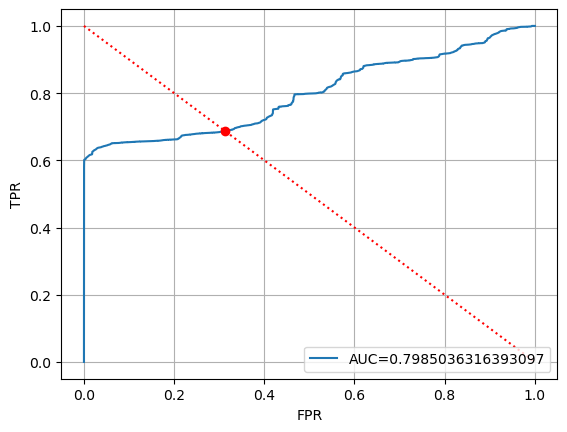

array([6.829167], dtype=float32)

In [24]:
threshold = ROC(y_test,y_pred)
threshold

best: 11.26530612244898 F1: 0.7492720454716392


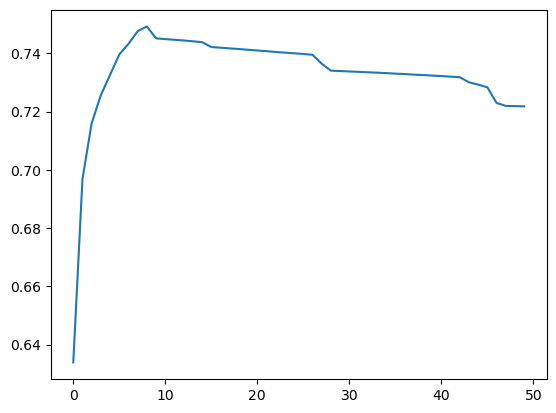

In [25]:
ff = 0
f_history = []
initial_y = 8
best = -1
for inc in np.linspace(0, 20, 50):
    y_pred_int = [1 if (yy > initial_y + inc) else 0 for yy in y_pred]
    conf_matrix = confusion_matrix(y_test, y_pred_int)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    F1 = f1_score(y_test, y_pred_int)
    f_history.append(F1)

    precision = precision_score(y_test, y_pred_int)
    recall = recall_score(y_test, y_pred_int)
    if F1 > ff:
        ff = F1
        best = inc
print(f'best: {best + initial_y} F1: {ff}')
plt.plot(f_history)

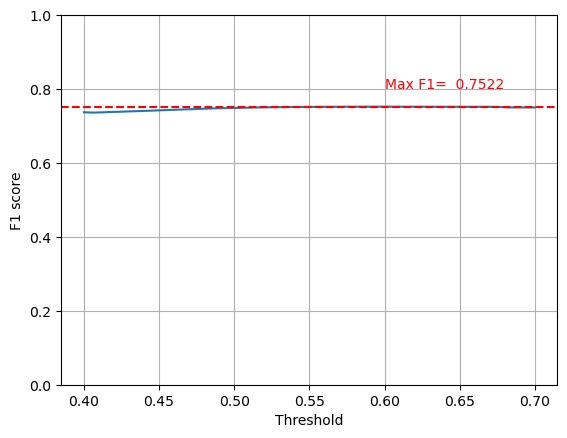

In [35]:
x_vals = 0.4 + np.linspace(0, 0.3, 50)
plt.plot(x_vals, f_history)
plt.xlabel('Threshold')
plt.ylabel('F1 score')

max_y = max(f_history)
max_x = np.argmax(f_history)
plt.axhline(y=max_y, color='r', linestyle='--', label='Max Y')
plt.text(0.6, max_y + 0.05, f'Max F1= {max_y: .4f}', color='r')
plt.ylim(0, 1)
plt.grid(True)

plt.savefig('my_plot.png')

plt.show()

In [42]:
y_pred_int = [1 if (yy > 32.3061) else 0 for yy in y_pred]
conf_matrix = confusion_matrix(y_test, y_pred_int)
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
F1 = f1_score(y_test, y_pred_int)

precision = precision_score(y_test, y_pred_int)
recall = recall_score(y_test, y_pred_int)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", F1)
print(f'TP: {TP}\nTN: {TN}\nFP: {FP}\nFN: {FN}')

Precision: 0.9920150038362081
Recall: 0.6197628177815652
F1 Score: 0.7629016925447175
TP: 34910
TN: 393260
FP: 281
FN: 21418
